In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
cluster.scale(24)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/envs/jul2021/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32908 instead
  warnings.warn(
distributed.diskutils - INFO - Found stale lock file and directory '/panfs/panasas/cnt0024/hmg2840/tuchida/notebooks/msqg/filter/dask-worker-space/worker-ts058noo', purging
distributed.diskutils - INFO - Found stale lock file and directory '/panfs/panasas/cnt0024/hmg2840/tuchida/notebooks/msqg/filter/dask-worker-space/worker-migaz65l', purging
distributed.diskutils - INFO - Found stale lock file and directory '/panfs/panasas/cnt0024/hmg2840/tuchida/notebooks/msqg/filter/dask-worker-space/worker-pg_8absl', purging
distributed.diskutils - INFO - Found stale lock file and directory '/panfs/panasas/cnt0024/hmg2840/tuchida/notebooks/msqg/filter/dask-worker-space/worker-bugw_rko', purging
distributed.diskutils - INFO - Found stale lock file and dir

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:32908/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:32908/status,Workers: 24
Total threads: 168,Total memory: 754.89 GiB
Comm: tcp://127.0.0.1:36384,Workers: 24
Dashboard: http://127.0.0.1:32908/status,Total threads: 168
Started: Just now,Total memory: 754.89 GiB
Comm: tcp://127.0.0.1:36525,Total threads: 7
Dashboard: http://127.0.0.1:44216/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:42619,


In [2]:
!squeue -u tuchida

import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          12252138      visu      viz  tuchida  R      12:01      1 n4368
24


In [3]:
import numpy as np
import xarray as xr
from xgcm.grid import Grid
import os.path as op
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ddir = '/store/tuchida/msom/msqg/filter/'

In [5]:
U = .1
tau = 5e5  # seconds
Rd = 5e4   # Rossby radius (50km)
Ro = .0215
N = 128
# N = 256    # Number of horizontal grids
# N = 512
L0 = 100
H = 5e3
dx = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd

In [5]:
dx*Rd

19531.25

In [6]:
ds = xr.open_dataset(op.join(ddir,'N128/outdir_0014/vars.nc'))
# ds = xr.open_dataset(op.join(ddir,'LfullHeddy/outdir_0007/vars.nc'))

ds = ds.rename({'t':'time','z':'Z','y':'YC','x':'XC'})
ds.coords['time'] = ('time',ds.time.data)
# ds.coords['Z'] = ('Z',np.array([.03,.13,.6]))
ds.coords['YG'] = ('YG',np.arange(0,L0,dx))
ds.coords['XG'] = ('XG',np.arange(0,L0,dx))
ds.coords['YC'] = ('YC',np.arange(dx/2,L0+dx/2,dx))
ds.coords['XC'] = ('XC',np.arange(dx/2,L0+dx/2,dx))
# ds.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
# ds.coords['drF'] = ('Z',np.array([0.04761905, 0.0952381 , 0.19047619, 0.66666667]))
# ds.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
ds

<xarray.Dataset>
Dimensions:  (XC: 128, XG: 128, YC: 128, YG: 128, Z: 4, time: 501)
Coordinates:
  * YC       (YC) float64 0.3906 1.172 1.953 2.734 ... 97.27 98.05 98.83 99.61
  * XC       (XC) float64 0.3906 1.172 1.953 2.734 ... 97.27 98.05 98.83 99.61
  * Z        (Z) float32 0.0 1.0 2.0 3.0
  * time     (time) float32 0.0 10.0 20.0 30.0 ... 4.98e+03 4.99e+03 5e+03
  * YG       (YG) float64 0.0 0.7812 1.562 2.344 ... 96.88 97.66 98.44 99.22
  * XG       (XG) float64 0.0 0.7812 1.562 2.344 ... 96.88 97.66 98.44 99.22
Data variables:
    p        (time, Z, YC, XC) float32 ...
    q        (time, Z, YC, XC) float32 ...
    pf       (time, Z, YC, XC) float32 ...

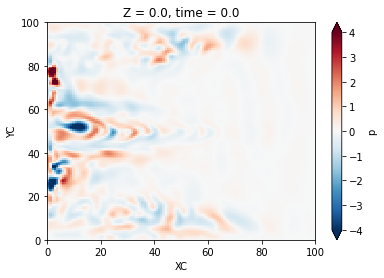

In [7]:
ds.p.isel(time=0,Z=0).plot(vmax=4)

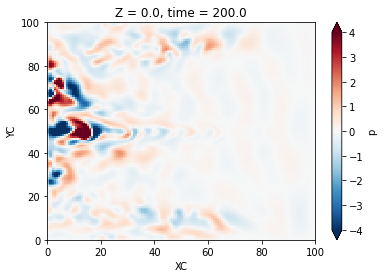

In [8]:
ds.p.isel(time=20,Z=0).plot(vmax=4)

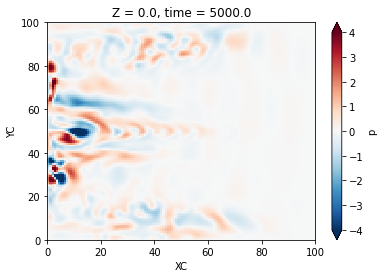

In [9]:
ds.p.isel(time=-1,Z=0).plot(vmax=4)

In [10]:
grid = Grid(ds, periodic=[],
            coords={'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}})
# gridz = Grid(ds.isel(Z=slice(1,-1),Zp1=slice(1,-1)), periodic=[],
#              coords={'Y':{'center':'YC','left':'YG'},
#                      'X':{'center':'XC','left':'XG'}})

In [10]:
Frm = xr.DataArray(np.array([0.0048984 , 0.00602457, 0.03548964]), dims='Zp1', 
                   coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))})
N0 = U/(Fr * H*ds.drC.isel(Zp1=slice(1,-1)))

AttributeError: 'Dataset' object has no attribute 'Zp1'

In [11]:
u = -grid.diff(ds.p,'Y',boundary='fill')/dx * U
v = grid.diff(ds.p,'X',boundary='fill')/dx * U
# b = (f0*U*Rd/H) * (grid.diff(ds.p,'Z',boundary='fill')
#                    / ds.drC).isel(Zp1=slice(1,-1))

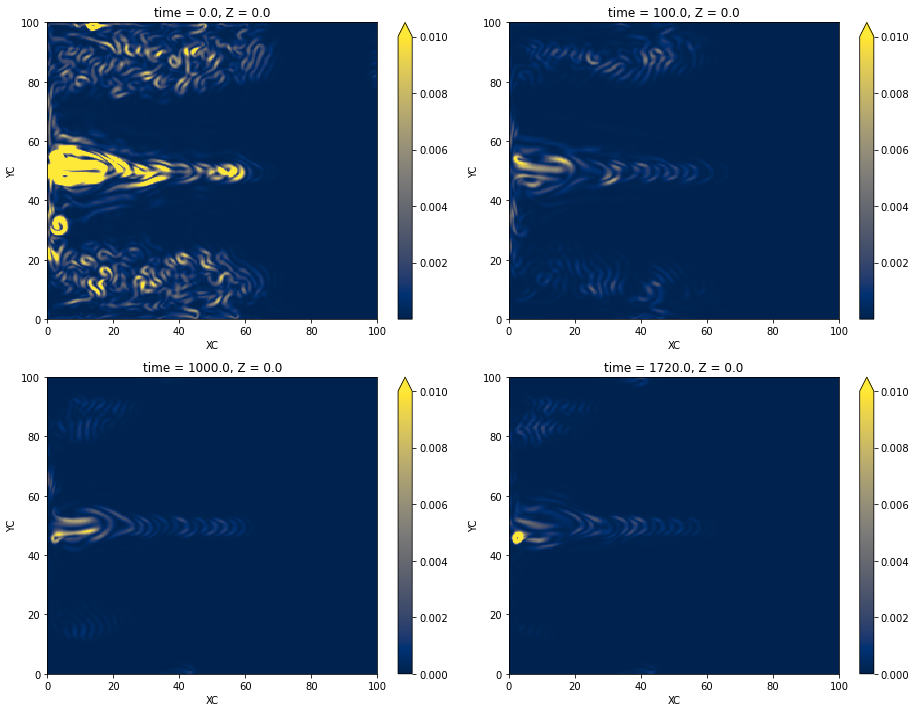

In [12]:
vort = (grid.diff(v,'X',boundary='fill') 
        - grid.diff(u,'Y',boundary='fill')) / Rd
KE = .5*(grid.interp(u**2,'Y',boundary='fill') 
         + grid.interp(v**2,'X',boundary='fill')
        )

fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)
KE.isel(time=0,Z=0).plot(ax=axes[0,0], cmap='cividis', vmax=1e-2)
KE.isel(time=10,Z=0).plot(ax=axes[0,1], cmap='cividis', vmax=1e-2)
KE.isel(time=100,Z=0).plot(ax=axes[1,0], cmap='cividis', vmax=1e-2)
KE.isel(time=-1,Z=0).plot(ax=axes[1,1], cmap='cividis', vmax=1e-2)

In [ ]:
KEbar = KE.sel(Z=0.03,YC=slice(20.,60.),XC=slice(None,60.)
              ).mean('nmemb').mean(['YC','XC']).compute()
KEstd_xy = KE.sel(Z=0.03,YC=slice(20.,60.),XC=slice(None,60.)
                 ).mean(['YC','XC']).std('nmemb').compute()
KEstd = KE.sel(Z=0.03,YC=slice(20.,60.),XC=slice(None,60.)
              ).std('nmemb').mean(['YC','XC']).compute()

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


In [ ]:
fig, ax = plt.subplots(figsize=(9,5))
fig.set_tight_layout(True)
ax2 = ax.twinx()

for i in range(nmemb+1):
    if i < nmemb:
        ax.plot(ds.time/(365*86400), KE.sel(Z=.03,YC=slice(20.,60.),XC=slice(0.,60.)
                                           ).isel(nmemb=i).mean(['YC','XC']))
    else:
        ax.plot(ds.time/(365*86400), KE.sel(Z=.03,YC=slice(20.,60.),XC=slice(0.,60.)
                                           ).isel(nmemb=i).mean(['YC','XC']), 
                'r--', label=r'ctrl', lw=3)

ax.plot(ds.time/(365*86400), KEbar, 
        'k--', lw=2, label=r'$\overline{KE}$')
ax.fill_between(ds.time/(365*86400), 
                (KEbar.mean(['YC','XC'])-KEstd_xy),
                (KEbar.mean(['YC','XC'])+KEstd_xy), 
                color='grey', alpha=.5)
ax2.plot(ds.time/(365*86400), KEstd, 
         'b-.', lw=3, label=r"$\sigma_{KE}$")

ax.set_xlim([0.,8.])
ax2.set_ylim([0.,.045])
ax.legend(loc='upper left', fontsize=14)
ax2.legend(loc='lower right', fontsize=14)
ax2.spines['right'].set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax.set_xlabel(r"[yr]", fontsize=12)
ax.grid(True)
plt.savefig(op.join(ddir,'../Figs/KE_seas_%03dmembs.pdf' % nmemb))

In [ ]:
up = u - u.mean('nmemb')
vp = v - v.mean('nmemb')
bp = b - b.mean('nmemb')
X = grid.interp((up**2).mean('nmemb'),'Y',boundary='fill')
Y = grid.interp((vp**2).mean('nmemb'),'X',boundary='fill')
M = .5*(Y - X)
N = (grid.interp(vp,'X',boundary='fill')
     * grid.interp(up,'Y',boundary='fill')).mean('nmemb')
P = .5*(bp**2).mean('nmemb') / N0**2
R = f0/N0**2 * (bp * grid.interp(grid.interp(up,'Y',boundary='fill'),
                                 'Z',boundary='fill')
               ).mean('nmemb')
S = f0/N0**2 * (bp * grid.interp(grid.interp(vp,'X',boundary='fill'),
                                 'Z',boundary='fill')
               ).mean('nmemb')
S

In [ ]:
fig, axes = plt.subplots(figsize=(11,13), nrows=3, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(ds.XC.sel(XC=slice(0,60.)), ds.YC.sel(YC=slice(10,70.)), 
                           (vort/f0).sel(YC=slice(10,70.),
                                         XC=slice(0,60.)).mean('nmemb').isel(Z=0,time=-16), 
                           vmin=-.02, vmax=.02, cmap='RdGy_r', rasterized=True)
im1 = axes[0,1].pcolormesh(ds.XC.sel(XC=slice(0,60.)), ds.YC.sel(YC=slice(10,70.)),
                           grid.interp(N,'Z',boundary='fill').sel(YC=slice(10,70.),
                                                                  XC=slice(0,60.),
                                                                  Zp1=.06).isel(time=-16), 
                           vmax=8e-3, vmin=-8e-3, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(ds.XC.sel(XC=slice(0,60.)), ds.YC.sel(YC=slice(10,70.)),
                           (grid.interp(X,'Z',boundary='fill')
                            + P).sel(YC=slice(10,70.), XC=slice(0,60.), Zp1=.06).isel(time=-16), 
                           vmax=.016, vmin=0, cmap='Reds', rasterized=True)
im3 = axes[1,1].pcolormesh(ds.XC.sel(XC=slice(0,60.)), ds.YC.sel(YC=slice(10,70.)),
                           (grid.interp(Y,'Z',boundary='fill')
                            + P).sel(YC=slice(10,70.), XC=slice(0,60.), Zp1=.06).isel(time=-16), 
                           vmax=.016, vmin=0, cmap='Reds', rasterized=True)
im4 = axes[2,0].pcolormesh(ds.XC.sel(XC=slice(0,60.)), ds.YC.sel(YC=slice(10,70.)),
                           -S.sel(YC=slice(10,70.),XC=slice(0,60.),
                                  Zp1=.06).isel(time=-16), 
                           vmax=5e-6, vmin=-5e-6, cmap='RdBu_r', rasterized=True)
im5 = axes[2,1].pcolormesh(ds.XC.sel(XC=slice(0,60.)), ds.YC.sel(YC=slice(10,70.)), 
                           R.sel(YC=slice(10,70.),XC=slice(0,60.),
                                 Zp1=.06).isel(time=-16), 
                           vmax=5e-6, vmin=-5e-6, cmap='RdBu_r', rasterized=True)

axes[0,0].set_title(r"$\overline{\zeta}/f$", fontsize=15)
axes[1,0].set_title(r"$\overline{u'u'} + \frac{\overline{b'^2}}{2 N_0^2}$", 
                    fontsize=15)
axes[0,1].set_title(r"$\overline{u'v'}$", fontsize=15)
axes[1,1].set_title(r"$\overline{v'v'} + \frac{\overline{b'^2}}{2 N_0^2}$", 
                    fontsize=15)
axes[2,0].set_title(r"$-\frac{f_0}{N_0^2}\overline{v'b'}$", 
                    fontsize=15)
axes[2,1].set_title(r"$\frac{f_0}{N_0^2}\overline{u'b'}$", 
                    fontsize=15)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
# cbar0.set_label(r"$(\times 10^{-4})$ [s$^{-2}$]", fontsize=12)
# cbar0.ax.set_yticklabels(style='sci')
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
cbar3.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar4 = fig.colorbar(im4, ax=axes[2,0], shrink=.7)
cbar4.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar5 = fig.colorbar(im5, ax=axes[2,1], shrink=.7)
cbar5.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)

# plt.savefig(op.join(ddir,'Figures/E-P_flux_adjusted-delta_1963-Dec-26.pdf'))

In [ ]:
e00_x = gridz.interp(gridz.interp(grid.diff(grid.interp(X,'Z',boundary='fill')+P,
                                            'X',boundary='fill'),
                                  'X',boundary='fill')
                     / (dx*Rd),'Z',boundary='fill')
e10_y = grid.interp(grid.diff(N,'Y',boundary='fill'),'Y',boundary='fill') / (dx*Rd)

e01_x = grid.interp(grid.diff(N,'X',boundary='fill'),'X',boundary='fill') / (dx*Rd)
e11_y = gridz.interp(gridz.interp(grid.diff(grid.interp(Y,'Z',boundary='fill')+P,
                                            'Y',boundary='fill'),
                                  'Y',boundary='fill')
                     / (dx*Rd),'Z',boundary='fill')

e20_z = -gridz.diff(-S,'Z',boundary='fill') / (H*ds.drF)
e21_z = -gridz.diff(R,'Z',boundary='fill') / (H*ds.drF)
e20_z

In [ ]:
Eu = e00_x + e10_y + e20_z
Ev = e01_x + e11_y + e21_z
Eu

In [ ]:
fig, axes = plt.subplots(figsize=(13,21), nrows=4, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(ds.XC.sel(XC=slice(0,60.)), ds.YC.sel(YC=slice(10,70.)), 
                          -e00_x.sel(YC=slice(10,70.),XC=slice(0,60.)).sel(Z=.13).isel(time=-16), 
                          vmax=4.5e-8, vmin=-4.5e-8,
                          cmap='RdBu_r', rasterized=True)
axes[1,0].pcolormesh(ds.XC.sel(XC=slice(0,60.)), ds.YC.sel(YC=slice(10,70.)), 
                     -e10_y.sel(YC=slice(10,70.),XC=slice(0,60.)).sel(Z=.13).isel(time=-16), 
                     vmax=4.5e-8, vmin=-4.5e-8,
                     cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(ds.XC.sel(XC=slice(0,60.)), ds.YC.sel(YC=slice(10,70.)), 
                     -e01_x.sel(YC=slice(10,70.),XC=slice(0,60.)).sel(Z=.13).isel(time=-16), 
                     vmax=4.5e-8, vmin=-4.5e-8,
                     cmap='RdBu_r', rasterized=True)
axes[1,1].pcolormesh(ds.XC.sel(XC=slice(0,60.)), ds.YC.sel(YC=slice(10,70.)), 
                     -e11_y.sel(YC=slice(10,70.),XC=slice(0,60.)).sel(Z=.13).isel(time=-16),
                     vmax=4.5e-8, vmin=-4.5e-8,
                     cmap='RdBu_r', rasterized=True)
axes[2,0].pcolormesh(ds.XC.sel(XC=slice(0,60.)), ds.YC.sel(YC=slice(10,70.)), 
                     -e20_z.sel(YC=slice(10,70.),XC=slice(0,60.)).sel(Z=.13).isel(time=-16), 
                     vmax=4.5e-8, vmin=-4.5e-8,
                     cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(ds.XC.sel(XC=slice(0,60.)), ds.YC.sel(YC=slice(10,70.)), 
                     -e21_z.sel(YC=slice(10,70.),XC=slice(0,60.)).sel(Z=.13).isel(time=-16),
                     vmax=4.5e-8, vmin=-4.5e-8,
                     cmap='RdBu_r', rasterized=True)
axes[3,0].pcolormesh(ds.XC.sel(XC=slice(0,60.)), ds.YC.sel(YC=slice(10,70.)), 
                     -Eu.sel(YC=slice(10,70.),XC=slice(0,60.)).sel(Z=.13).isel(time=-16),
                     vmax=4.5e-8, vmin=-4.5e-8,
                     cmap='RdBu_r', rasterized=True)
axes[3,1].pcolormesh(ds.XC.sel(XC=slice(0,60.)), ds.YC.sel(YC=slice(10,70.)), 
                     -Ev.sel(YC=slice(10,70.),XC=slice(0,60.)).sel(Z=.13).isel(time=-16),
                     vmax=4.5e-8, vmin=-4.5e-8,
                     cmap='RdBu_r', rasterized=True)


axes[0,0].set_title(r"$-(\overline{u'u'} + \frac{\overline{b'^2}}{2 N_0^2})_x$", 
                    fontsize=14)
axes[1,0].set_title(r"$-(\overline{v'u'})_y$", 
                    fontsize=14)
axes[0,1].set_title(r"$-(\overline{u'v'})_x$", 
                    fontsize=14)
axes[1,1].set_title(r"$-(\overline{v'v'} + \frac{\overline{b'^2}}{2 N_0^2})_y$", 
                    fontsize=14)
axes[2,0].set_title(r"$(\frac{f_0}{N_0^2}\overline{v'b'})_z$", 
                    fontsize=14)
axes[2,1].set_title(r"$-(\frac{f_0}{N_0^2}\overline{u'b'})_z$", 
                    fontsize=14)
axes[3,0].set_title(r"$-{\bf e}_x \cdot(\nabla\cdot{\bf E})$", fontsize=14)
axes[3,1].set_title(r"$-{\bf e}_y \cdot(\nabla\cdot{\bf E})$", fontsize=14)

axes[3,0].set_xlabel(r"Longitude", fontsize=13)
axes[3,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)
axes[3,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.35, 0.018, 0.3]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
                   ticks=1e-8*np.array([-4.5,-3,-1.5,0,1.5,3,4.5]))
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"[m s$^{-2}$]", fontsize=12)

# plt.savefig(op.join(ddir,'Figures/DivE-P_flux_adjusted-delta_1963-Dec-26.pdf'))